# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [111]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

from utils import util

In [112]:
from importlib import reload  
from utils import util
util = reload(util)

In [113]:
# Set random seed for reproducibility
def fix_random_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed=84 #24 SI, 42 NO, 84 SI
fix_random_seed(seed)

## 1. Load and inspect the dataset

### 1.1. Load data

In [114]:
df, df_indexes_test = util.load_data(colab)
print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [115]:
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


### 1.2. Preprocess and split the dataset

In [116]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


In [117]:
df = util.standardize(df, 'gumbel')

#### 1.2.1 Split the dataset into train, validation and test

In [118]:
# Take the first 100 ID and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]

test_df = df[df['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

# Drop the test set from df and then create the train sets and validation sets
df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])

train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [119]:
train_df.head()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001.0,1.221239,28.250,0.890564,0.184415,1.0,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
1,5001.0,0.680425,199.875,0.859361,0.219803,24.0,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
2,5001.0,0.855535,199.875,0.859361,0.219803,24.0,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
3,5001.0,0.945591,199.875,0.859361,0.219803,24.0,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
4,5001.0,1.518449,199.875,0.859361,0.219803,24.0,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952


#### 1.2.2 Standardize datasets

In [120]:
train_df_std = train_df #util.standardize(train_df, 'gumbel')
val_df_std = val_df #util.standardize(val_df, 'gumbel')
test_df_std = test_df #util.standardize(test_df, 'gumbel')

In [121]:
# column ID must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration[h] must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [122]:
train_df_std.head()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,1.221239,28.250,0.890564,0.184415,1,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
1,5001,0.680425,199.875,0.859361,0.219803,24,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
2,5001,0.855535,199.875,0.859361,0.219803,24,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
3,5001,0.945591,199.875,0.859361,0.219803,24,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
4,5001,1.518449,199.875,0.859361,0.219803,24,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952


In [123]:
train_df_std.describe()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,2.332180e+05,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,0.999994,57.052651,0.840404,2.670913e-01,9.199200,0.024646,0.032570,0.042734,0.047496,...,-0.102764,0.028934,-0.070270,-0.067010,0.023610,0.001521,0.037728,0.004899,-0.072880,-0.075678
std,4333.130131,0.375311,31.051531,0.034366,5.204271e-02,8.280664,0.984392,0.986320,0.981766,0.976423,...,0.986101,1.052469,1.018725,1.018695,0.996458,1.002549,0.995037,1.018041,0.989454,1.016837
min,5001.000000,0.008228,5.200000,0.563792,6.394417e-304,1.000000,-1.020500,-1.181048,-1.331852,-1.503806,...,-1.470102,-1.519984,-1.779005,-1.935638,-1.583809,-0.479600,-1.528887,-0.637763,-2.037322,-1.886456
25%,8094.000000,0.746687,34.984444,0.820754,2.357013e-01,3.000000,-0.708747,-0.817296,-0.887690,-0.666054,...,-0.984027,-0.582172,-0.864855,-0.799420,-0.757122,-0.452740,-0.764904,-0.515773,-0.969827,-0.868411
50%,12005.000000,0.931278,49.674286,0.841520,2.668687e-01,6.000000,-0.264208,-0.091967,0.073687,0.116867,...,-0.148547,-0.118672,-0.208966,-0.251402,-0.210103,-0.420647,-0.187105,-0.435802,0.079379,-0.371707
75%,16065.000000,1.171738,70.343750,0.862298,2.976202e-01,12.000000,0.480086,0.640557,0.730073,0.713190,...,0.563731,0.423661,0.582830,0.456927,0.596341,-0.225321,0.667556,-0.095920,0.699596,0.724815
max,20034.000000,6.288661,318.742857,1.000000,6.725157e-01,24.000000,5.244876,3.734721,2.928541,3.520526,...,2.408305,5.536860,3.648605,3.272980,4.323812,7.312002,3.537003,6.218626,2.054450,2.471653


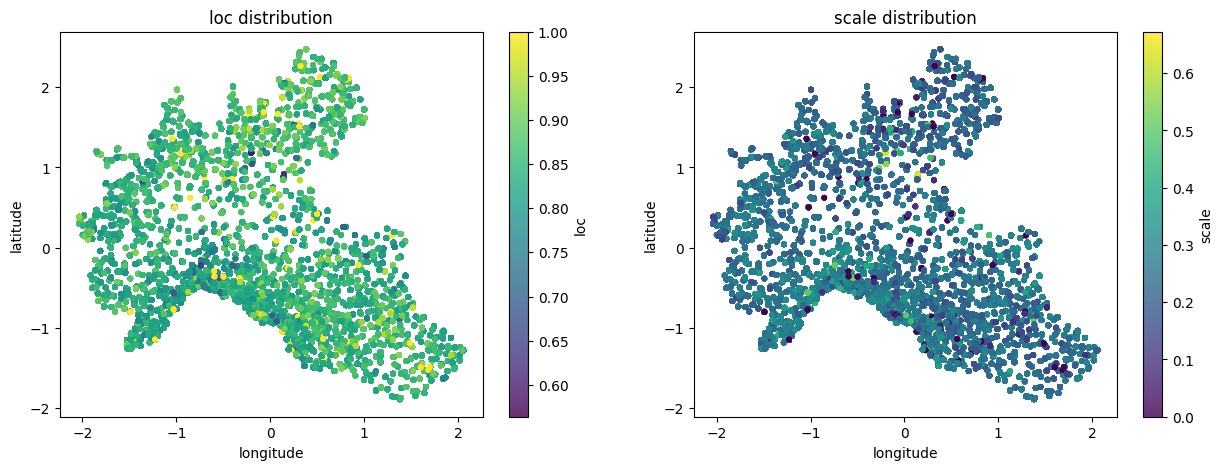

In [124]:
util.geographic_plot(train_df_std, 'loc', 'scale')

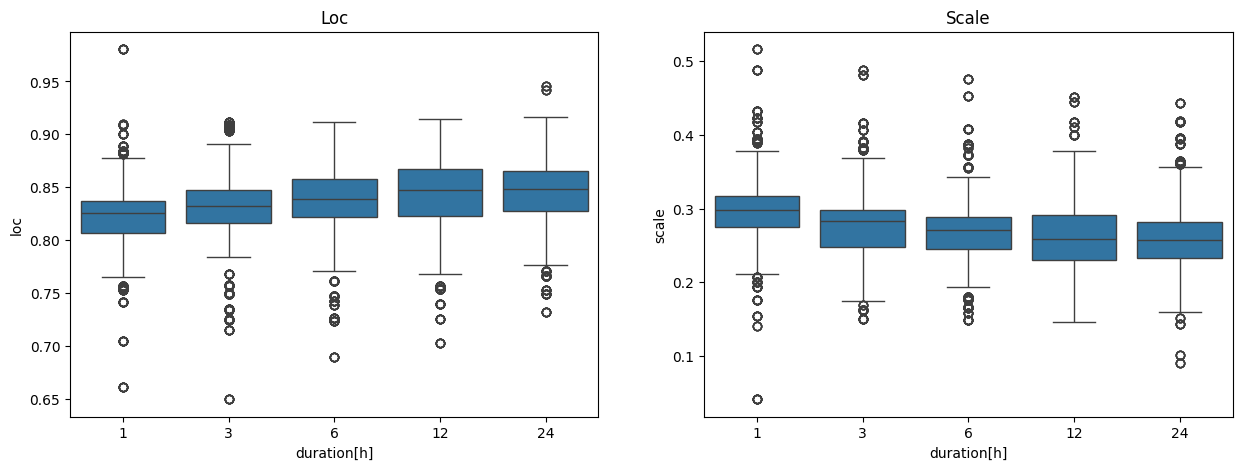

In [125]:
#boxplot of loc and scale
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='duration[h]', y='loc', data=test_df_std, ax=ax[0])
ax[0].set_title('Loc')

sns.boxplot(x='duration[h]', y='scale', data=test_df_std, ax=ax[1])
ax[1].set_title('Scale')

plt.show()

In [126]:
AMS_count = test_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['loc'] = test_df_std.groupby(['ID','duration[h]'])['loc'].mean() #prendo la media tanto lo stesso valore è ripetuto
AMS_count['scale'] = test_df_std.groupby(['ID','duration[h]'])['scale'].mean()

AMS_count.head(15)

count       loc     scale
ID   duration[h]                           
5005 1               64  0.825731  0.286071
     3               64  0.828158  0.281009
     6               64  0.832412  0.271395
     12              64  0.837870  0.275187
     24              64  0.846214  0.259406
5007 1               20  0.834123  0.286670
     3               20  0.794667  0.330951
     6               20  0.817620  0.306639
     12              20  0.857670  0.262769
     24              20  0.880146  0.225763
5015 1               76  0.858022  0.251708
     3               76  0.879860  0.209240
     6               77  0.880802  0.205946
     12              78  0.877962  0.203477
     24              77  0.868152  0.221819

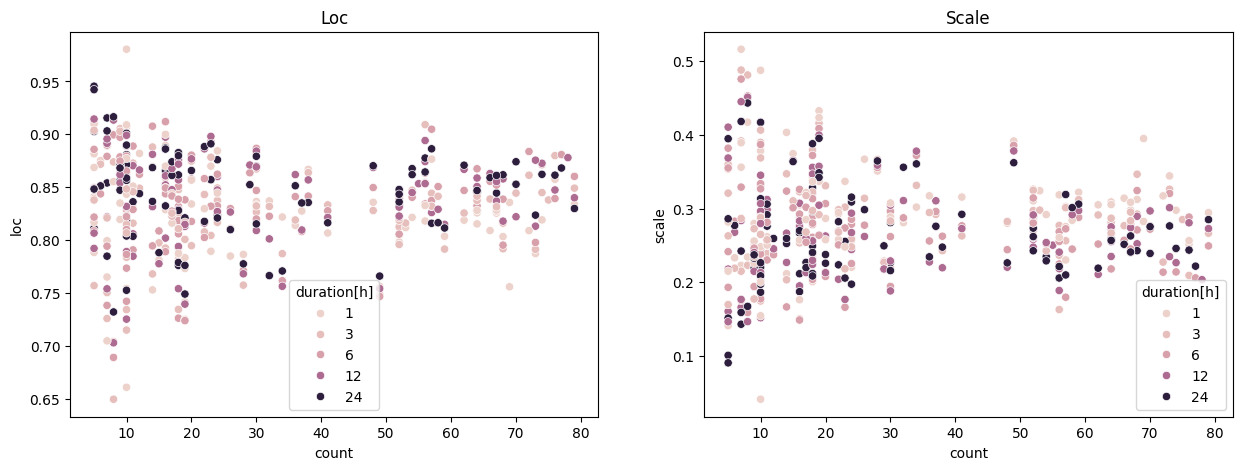

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='loc', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Loc')

sns.scatterplot(x='count', y='scale', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Scale')

plt.show()

### 1.3. Prepare data for training

In [128]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [129]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'loc', 'scale', 'duration[h]',
       'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [130]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns = columns[5:]  
output_column = 'AMS'
parameters_columns = ['ID', 'duration[h]', 'loc', 'scale']
print('Input columns: ', input_columns)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [131]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [132]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
15,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
5,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
6,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
7,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233201,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1
233202,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1
233203,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1
233204,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1


In [133]:
#MAP
inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,2.185839,1,0,0,0,0
15,2.185839,1,0,0,0,0
5,2.185839,0,1,0,0,0
6,2.185839,0,1,0,0,0
7,2.185839,0,1,0,0,0
...,...,...,...,...,...,...
233201,-0.125310,0,0,0,0,1
233202,-0.125310,0,0,0,0,1
233203,-0.125310,0,0,0,0,1
233204,-0.125310,0,0,0,0,1


In [134]:
#PCA
inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test, 5)

inputs_train_pca


,0,1,2,3,4
0,4.122771,-0.393521,-0.708337,5.286269,0.040013
1,4.122771,-0.393521,-0.708337,5.286269,0.040013
2,4.122777,-0.393565,-0.708371,5.286445,0.040039
3,4.122777,-0.393565,-0.708371,5.286445,0.040039
4,4.122777,-0.393565,-0.708371,5.286445,0.040039
...,...,...,...,...,...
233213,5.980451,1.973480,2.164376,-0.433023,0.024087
233214,5.980451,1.973480,2.164376,-0.433023,0.024087
233215,5.980451,1.973480,2.164376,-0.433023,0.024087
233216,5.980451,1.973480,2.164376,-0.433023,0.024087


## 2. Model definition

#### 2.1 Base model

In [135]:
def build_nn_gumbel_model(input_shape, hidden, seed):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    
    for h in hidden:
        x = layers.Dense(h, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    
    mu_logsig = layers.Dense(2, activation='linear',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    lf = lambda t: tfp.distributions.Gumbel(loc=t[:, :1], scale=(1e-6)+tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = keras.Model(model_in, model_out)
    
    return model

## 3. Training

### 3.1  MAP Training

In [136]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [137]:
# Parameters for the training
batch_size = 128
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

Training the model with only MAP descriptor...
Epoch 1/90


1823/1823 [==============================] - 4s 2ms/step - loss: 0.3257 - val_loss: 0.2657
Epoch 2/90
1823/1823 [==============================] - 3s 2ms/step - loss: 0.3124 - val_loss: 0.2893
Epoch 3/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3105 - val_loss: 0.2749
Epoch 4/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3093 - val_loss: 0.2580
Epoch 5/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3083 - val_loss: 0.2586
Epoch 6/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3078 - val_loss: 0.2673
Epoch 7/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3073 - val_loss: 0.2602
Epoch 8/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3072 - val_loss: 0.2582
Epoch 9/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3069 - val_loss: 0.2732
Epoch 10/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3067 - val_los

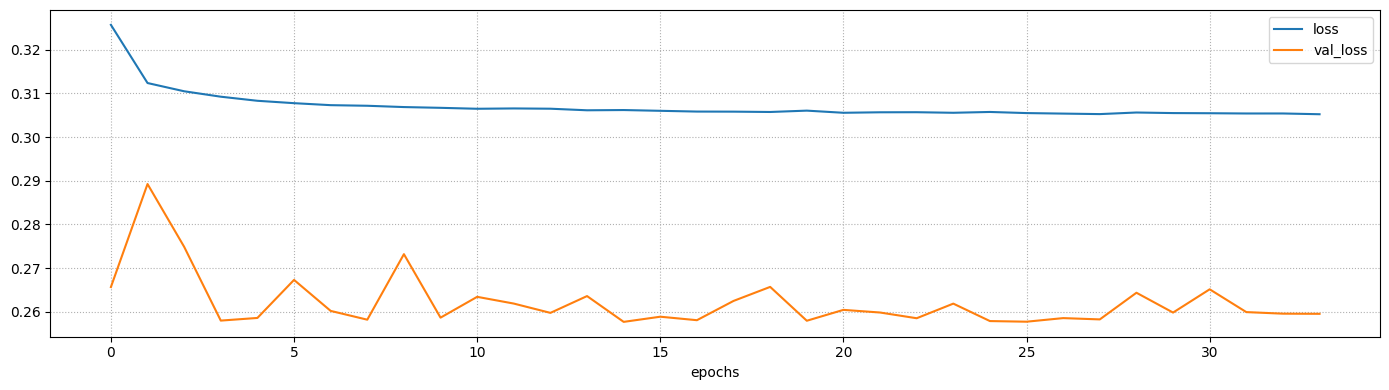

Final loss: 0.3052 (training), 0.2596 (validation)


In [138]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_gumbel_model(input_shape=(X_train_map.shape[1],), hidden=[256,128], seed=seed) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.2 Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 3s 1ms/step - loss: 0.3413 - val_loss: 0.3266
Epoch 2/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3076 - val_loss: 0.2796
Epoch 3/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3022 - val_loss: 0.2668
Epoch 4/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3000 - val_loss: 0.2750
Epoch 5/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2984 - val_loss: 0.2659
Epoch 6/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2963 - val_loss: 0.2733
Epoch 7/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2949 - val_loss: 0.2537
Epoch 8/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2943 - val_loss: 0.2600
Epoch 9/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.2932 - val_loss: 0.2709
Epoch 10/90
1823/1823 [=

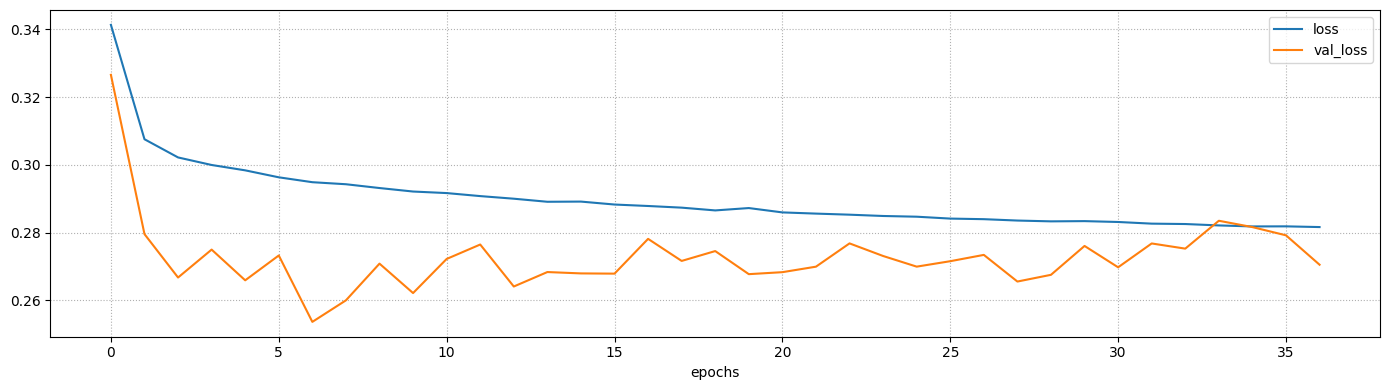

Final loss: 0.2817 (training), 0.2705 (validation)


In [139]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test.values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_gumbel_model(input_shape=(X_train.shape[1],), hidden=[256,128],seed=seed) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.3 PCA-model

Training the model with the PCA of the morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 3s 1ms/step - loss: 0.3470 - val_loss: 0.8705
Epoch 2/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3105 - val_loss: 0.3166
Epoch 3/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3064 - val_loss: 0.2878
Epoch 4/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3038 - val_loss: 0.2629
Epoch 5/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3028 - val_loss: 0.2672
Epoch 6/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3017 - val_loss: 0.2729
Epoch 7/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3009 - val_loss: 0.2637
Epoch 8/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3007 - val_loss: 0.2659
Epoch 9/90
1823/1823 [==============================] - 2s 1ms/step - loss: 0.3002 - val_loss: 0.2753
Epoch 10/90
1

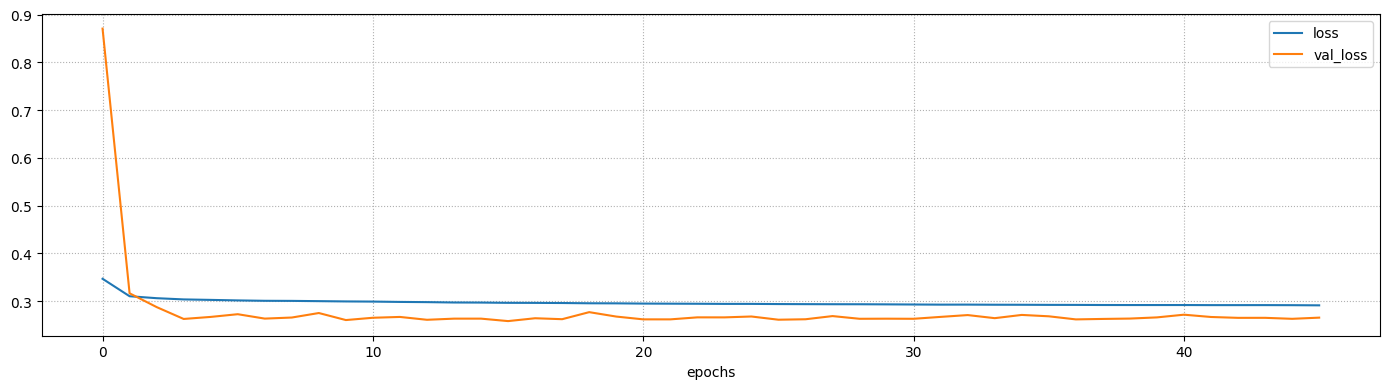

Final loss: 0.2914 (training), 0.2657 (validation)


In [140]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_gumbel_model(input_shape=(X_train_pca.shape[1],), hidden=[256,128],seed=seed) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

## 4. Evaluation

In [141]:
results = pd.DataFrame()

In [142]:
model_names = [ 'MAP', 'Full', 'PCA']
splits = ['Train', 'Validation', 'Test']
models = [map_model, full_model, pca_model]
X_values = {'MAP':[X_train_map, X_val_map, X_test_map], 'Full':[X_train, X_val, X_test], 'PCA':[X_train_pca, X_val_pca, X_test_pca]}
y_values = [y_train, y_val, y_test]
k = 0
for i, model_name in enumerate(model_names): 
    for j in range(3): #splits
        results[k] = util.evaluation(models[i], X_values[model_name][j], y_values[j], model_name, splits[j])
        k += 1

dist_train_map = map_model(X_train_map)
dist_val_map = map_model(X_val_map)
dist_test_map = map_model(X_test_map)

dist_train_full = full_model(X_train)
dist_val_full = full_model(X_val)
dist_test_full = full_model(X_test)

dist_train_pca = pca_model(X_train_pca)
dist_val_pca = pca_model(X_val_pca)
dist_test_pca = pca_model(X_test_pca)


Evaluating the MAP model on Train set...


Evaluating the MAP model on Validation set...
Evaluating the MAP model on Test set...
Evaluating the Full model on Train set...
Evaluating the Full model on Validation set...
Evaluating the Full model on Test set...
Evaluating the PCA model on Train set...
Evaluating the PCA model on Validation set...
Evaluating the PCA model on Test set...


In [143]:
results = results.T
results.columns=['Split', 'MAE', 'KS statistics']
display(results)

,Split,MAE,KS statistics
0,Train,0.385215,0.0174
1,Validation,0.37678,0.021378
2,Test,0.388529,0.026792
3,Train,0.382489,0.018819
4,Validation,0.375365,0.022575
5,Test,0.393497,0.022121
6,Train,0.385284,0.009845
7,Validation,0.373897,0.013854
8,Test,0.391912,0.016607


### 4.1 Distribution mean - confidence interval 

In [144]:
confidence = 0.99

Evaluation of MAP-model based on confidence intervals..


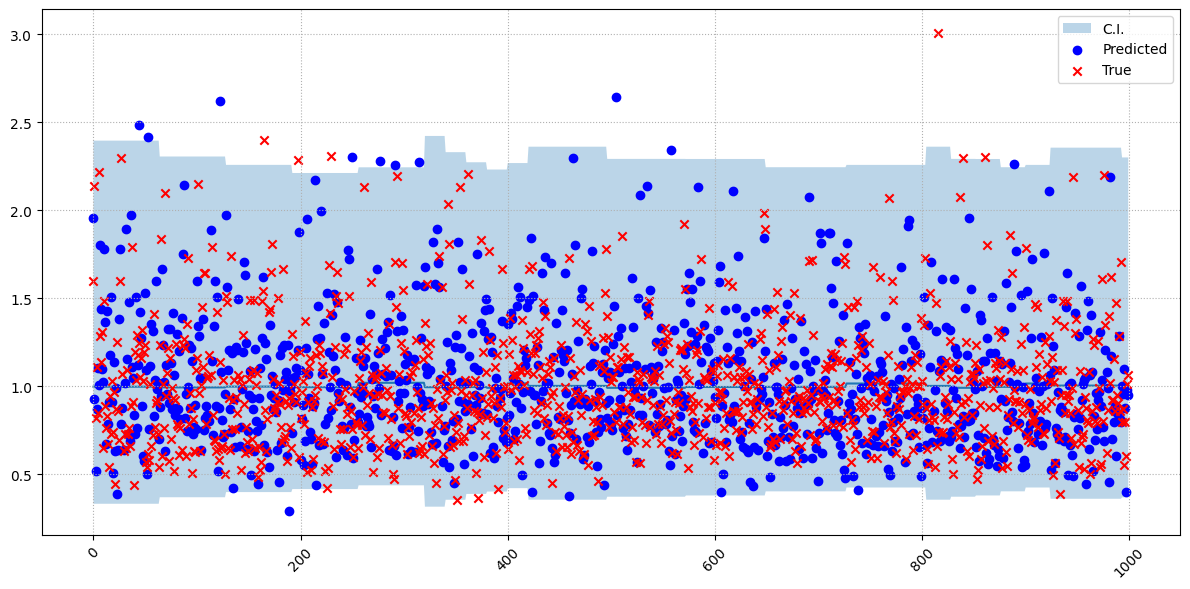

Percentage of values inside the 99% confidence interval: 98.16%


In [145]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


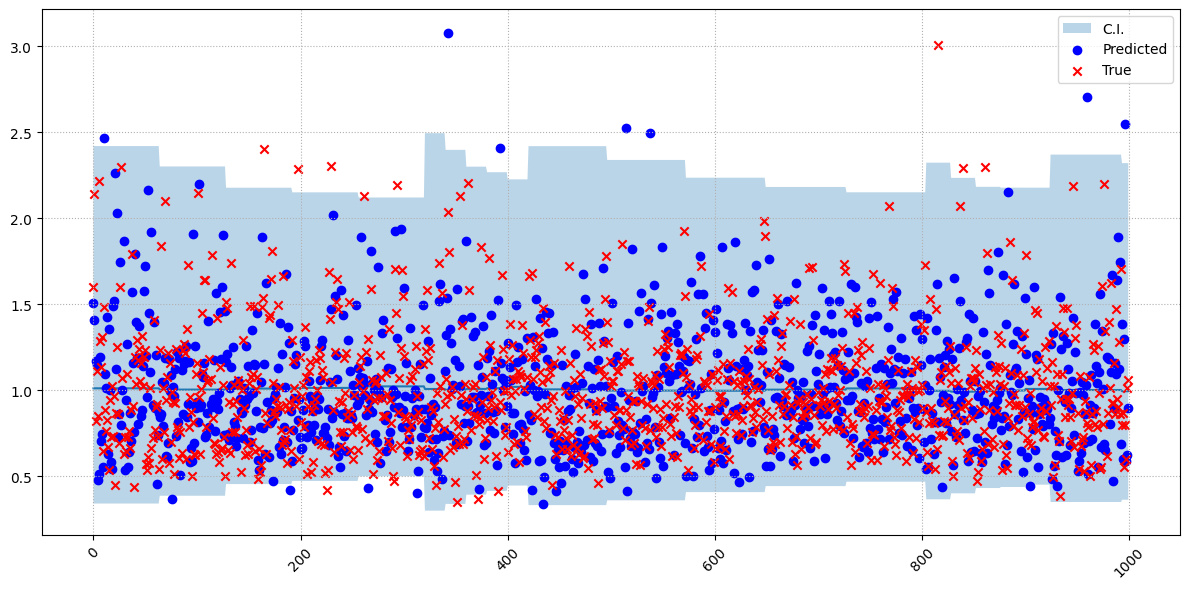

Percentage of values inside the 99% confidence interval: 98.22%


In [146]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of PCA-model based on confidence intervals..


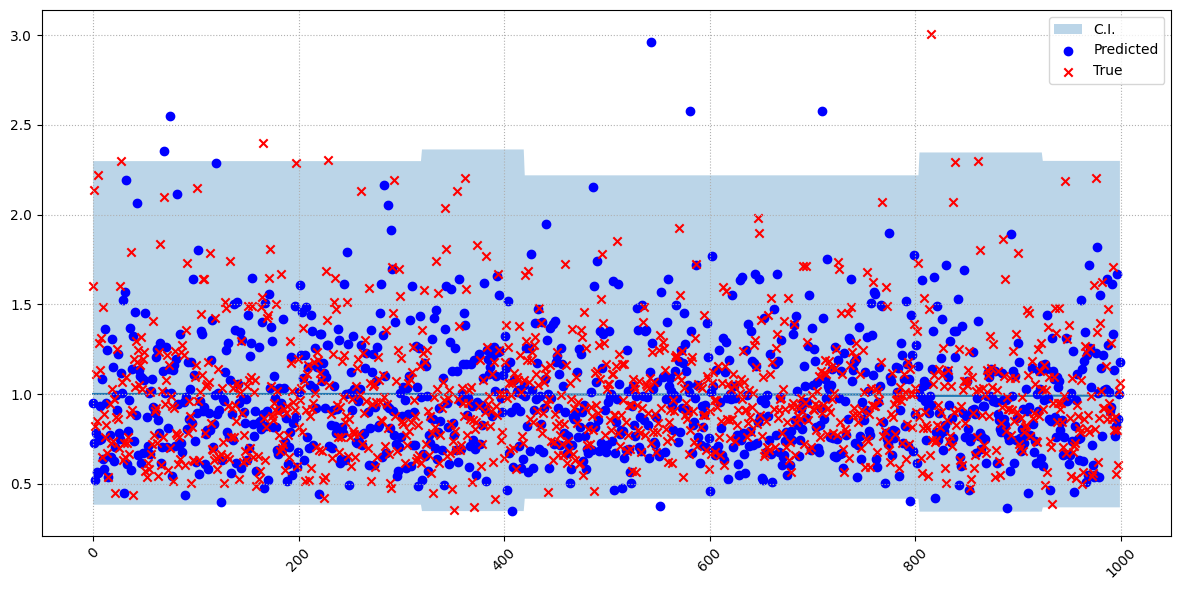

Percentage of values inside the 99% confidence interval: 98.21%


In [147]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

## 5. Parameters

* Metrics on parameters from MAP-model

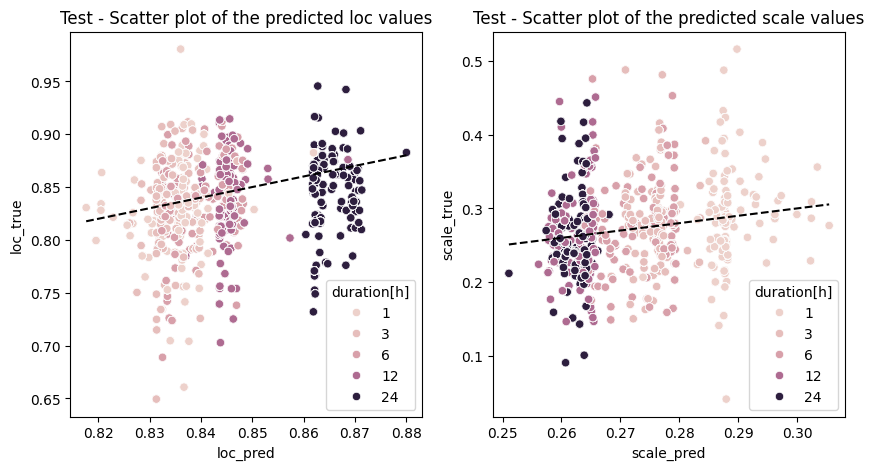

In [148]:
#_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_map, metrics_scale_map = util.parameters_metrics(dist_test_map, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [149]:
print('===============LOC PARAMETER===============')
display(metrics_loc_map)
print('===============SCALE PARAMETER==============')
metrics_scale_map

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.011873,-0.015489,-0.007116,-0.004082,-0.005825,-0.026873
mape,0.031753,0.032220,0.030518,0.030983,0.030684,0.034364
pcc,0.205372,0.099632,0.075967,0.192190,0.120115,0.115645


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.027130,-0.018931,-0.014161,-0.048600,-0.024521,-0.029439
mape,0.135962,0.136311,0.128128,0.139052,0.141464,0.134848
pcc,0.268753,0.075869,0.051789,0.193629,0.145655,0.099500


* Metrics on parameters from Full-model

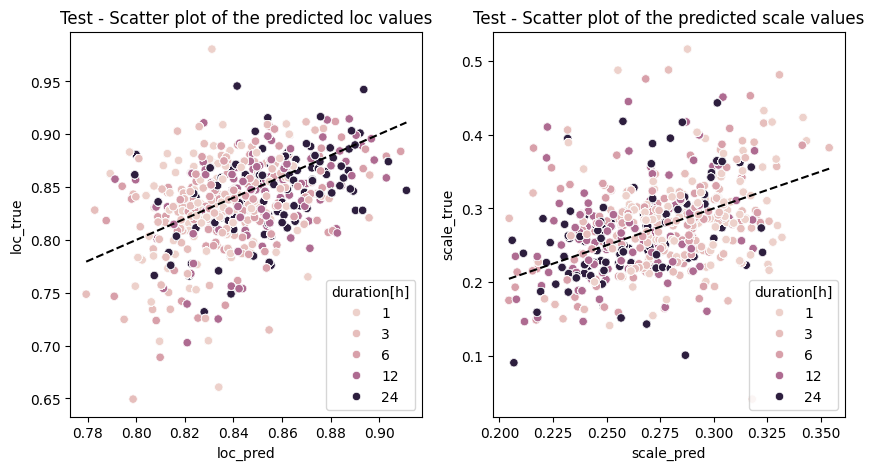

In [150]:
#_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_full, metrics_scale_full = util.parameters_metrics(dist_test_full, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [151]:
print('===============LOC PARAMETER===============')
display(metrics_loc_full)
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.011264,-0.011099,-0.006264,-0.009038,-0.012348,-0.017579
mape,0.031883,0.033338,0.030791,0.031268,0.032013,0.032005
pcc,0.430164,0.154429,0.412882,0.450039,0.404858,0.455194


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.018770,-0.032250,-0.020948,-0.019928,-0.011581,-0.009121
mape,0.130949,0.143582,0.121989,0.125390,0.135160,0.128611
pcc,0.462619,0.218955,0.430015,0.453712,0.425883,0.469171


* Metrics on parameters from PCA-model

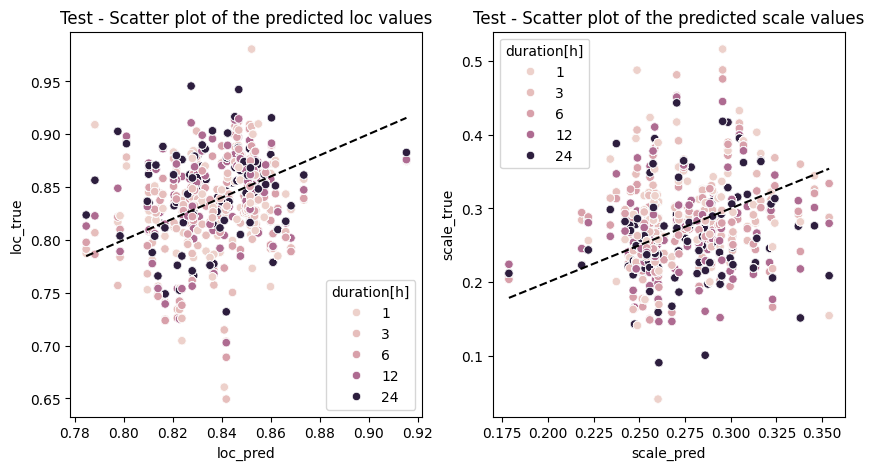

In [152]:
#_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_pca, metrics_scale_pca = util.parameters_metrics(dist_test_pca, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [153]:
print('===============LOC PARAMETER===============')
display(metrics_loc_pca)
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.003923,-0.018307,-0.010860,-0.000943,0.003702,0.006813
mape,0.032736,0.035236,0.032041,0.031949,0.032432,0.032018
pcc,0.246624,0.233698,0.312471,0.277974,0.223461,0.212901


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.018770,-0.032250,-0.020948,-0.019928,-0.011581,-0.009121
mape,0.130949,0.143582,0.121989,0.125390,0.135160,0.128611
pcc,0.462619,0.218955,0.430015,0.453712,0.425883,0.469171


### 5.1  Comparison between two samples extracted from "true" and predicted distribution of the same place 

True loc :  0.7834167698646965 Predicted  loc : 0.8569807
True scale :  0.3001078163133484 Predicted  scale : 0.25501376


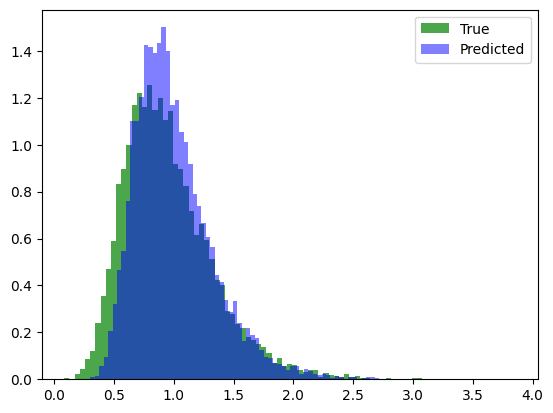

In [154]:
util.compare_samples(dist_train_full, "gumbel", parameters_train, index=70)
#util.compare_samples(dist_train_map, "gumbel", parameters_train, index=9)
#util.compare_samples(dist_train_pca, "gumbel", parameters_train, index=9)

## 6. Save results 


In [155]:
metrics_name = ['biasr', 'mape', 'pcc']
models_name = ['map', 'full', 'pca']
models_metrics = [ metrics_scale_map, metrics_scale_full, metrics_scale_pca]

In [156]:
scale_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
scale_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.027130,-0.018770,-0.037835,0.135962,0.130949,0.152550,0.268753,0.462619,0.194571
1,-0.018931,-0.032250,0.033149,0.136311,0.143582,0.150412,0.075869,0.218955,0.207505
3,-0.014161,-0.020948,-0.010389,0.128128,0.121989,0.135846,0.051789,0.430015,0.256047
6,-0.048600,-0.019928,-0.058555,0.139052,0.125390,0.151761,0.193629,0.453712,0.214237
12,-0.024521,-0.011581,-0.073266,0.141464,0.135160,0.165043,0.145655,0.425883,0.160475
24,-0.029439,-0.009121,-0.080193,0.134848,0.128611,0.159698,0.099500,0.469171,0.167302


In [157]:
models_metrics = [ metrics_loc_map, metrics_loc_full, metrics_loc_pca]
loc_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
loc_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.011873,-0.011264,-0.003923,0.031753,0.031883,0.032736,0.205372,0.430164,0.246624
1,-0.015489,-0.011099,-0.018307,0.032220,0.033338,0.035236,0.099632,0.154429,0.233698
3,-0.007116,-0.006264,-0.010860,0.030518,0.030791,0.032041,0.075967,0.412882,0.312471
6,-0.004082,-0.009038,-0.000943,0.030983,0.031268,0.031949,0.192190,0.450039,0.277974
12,-0.005825,-0.012348,0.003702,0.030684,0.032013,0.032432,0.120115,0.404858,0.223461
24,-0.026873,-0.017579,0.006813,0.034364,0.032005,0.032018,0.115645,0.455194,0.212901


In [158]:
#export as pkl file  loc and scale metrics
loc_metrics.to_pickle('results/loc_metrics.pkl')
scale_metrics.to_pickle('results/scale_metrics.pkl')
